In [104]:
import os

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

import albumentations as A
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

import segmentation_models_pytorch as smp

In [89]:
# constants

ENCODER_NAME = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
batch_size = 8
num_epochs = 20

# preprocessing parameters:
smp.encoders.get_preprocessing_params(ENCODER_NAME)

{'input_space': 'RGB',
 'input_range': [0, 1],
 'mean': [0.485, 0.456, 0.406],
 'std': [0.229, 0.224, 0.225]}

In [116]:
class MySegmentDataset(Dataset):
    CLASS_NAMES = ["background", "person", "car", "bus", "truck"]

    def __init__(
            self,
            csv_file,
            transforms=None,
            split="train"
        ):
        self.transforms = transforms
        self.split = split
        df = pd.read_csv(csv_file)
        df_selected = df[df["split"] == split]
        self.img_files = df_selected["imagepath"].values
        self.mask_files = df_selected["maskpath"].values

        class_values = np.linspace(0, 255, len(self.CLASS_NAMES), dtype="uint8")
        # map values to range(0, n):
        self.class_map = dict(zip(class_values, range(len(self.CLASS_NAMES))))
        print("Class map:", self.class_map)
        self.preprocessing_fn = smp.encoders.get_preprocessing_fn(
            ENCODER_NAME, ENCODER_WEIGHTS
        )

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        mask_path = self.mask_files[idx]

        #image = read_image(img_path)
        #mask = read_image(mask_path)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # remap mask values
        mask = np.vectorize(self.class_map.get)(mask)

        if self.transforms:
            output_dict = self.transforms(image=image, mask=mask)
            image = output_dict["image"]
            mask = output_dict["mask"]

        # normalize image
        image = self.preprocessing_fn(image)
        image = image.transpose(2, 0, 1)
        mask = mask[np.newaxis, :, :]

        return torch.FloatTensor(image), torch.LongTensor(mask)
    

Class map: {0: 0, 63: 1, 127: 2, 191: 3, 255: 4}
img: torch.Size([3, 480, 640]) min: -2.12 max: 2.64, msk: torch.Size([1, 480, 640]) unique values: [0 3 4]
img: torch.Size([3, 640, 427]) min: -2.12 max: 2.64, msk: torch.Size([1, 640, 427]) unique values: [0 1]
img: torch.Size([3, 428, 640]) min: -2.12 max: 2.64, msk: torch.Size([1, 428, 640]) unique values: [0 1 2]
img: torch.Size([3, 427, 640]) min: -2.12 max: 2.64, msk: torch.Size([1, 427, 640]) unique values: [0 1]
img: torch.Size([3, 575, 575]) min: -2.12 max: 2.64, msk: torch.Size([1, 575, 575]) unique values: [0 1 2]


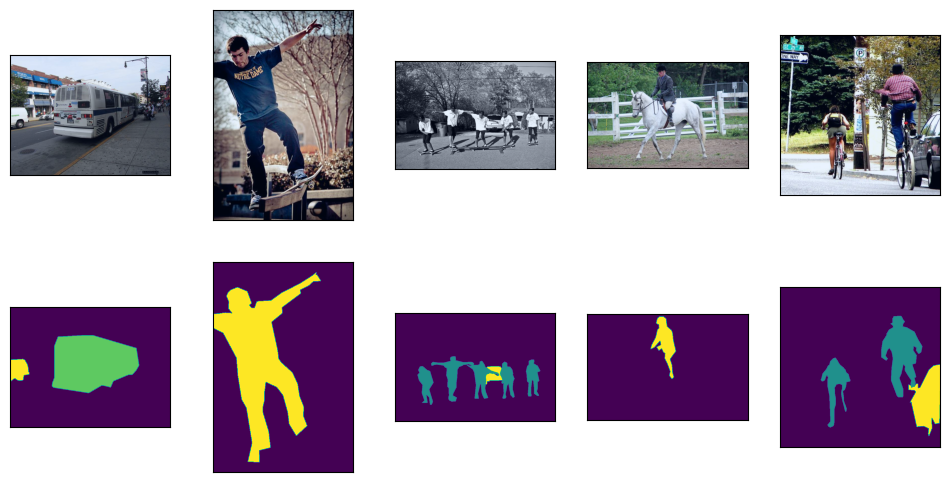

In [117]:
# build a dataset
train_dataset = MySegmentDataset(
    csv_file="data/data.csv",
    transforms=None,
    split="train"
)


fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
for i in range(5):
    img, msk = train_dataset[i]
    print(
        f"img: {img.shape} min: {img.min():.2f} max: {img.max():.2f}, "
        f"msk: {msk.shape} unique values: {np.unique(msk)}"
    )
    img = img.permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())
    axes[0, i].imshow(img)
    axes[1, i].imshow(msk[0])
    
[[ax.set_xticks([]), ax.set_yticks([])]  for ax in axes.flatten()]
plt.show()

In [118]:

# Reference: 
# https://github.com/qubvel-org/segmentation_models.pytorch
# /blob/main/examples/camvid_segmentation_multiclass.ipynb
# training set images augmentation
def get_train_augmentation():
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(
            scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0
        ),
        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True),
        A.RandomCrop(height=320, width=320, always_apply=True),
        A.GaussNoise(p=0.2),
        A.Perspective(p=0.5),
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightnessContrast(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return A.Compose(train_transform)


def get_val_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480),
    ]
    return A.Compose(test_transform)

Class map: {0: 0, 63: 1, 127: 2, 191: 3, 255: 4}
img: torch.Size([3, 320, 320]) min: -2.12 max: 0.83, msk: torch.Size([1, 320, 320]) unique values: [0 3]
img: torch.Size([3, 320, 320]) min: -2.12 max: 2.64, msk: torch.Size([1, 320, 320]) unique values: [0 1]
img: torch.Size([3, 320, 320]) min: -2.12 max: 2.27, msk: torch.Size([1, 320, 320]) unique values: [0 1 2]
img: torch.Size([3, 320, 320]) min: -2.12 max: 2.64, msk: torch.Size([1, 320, 320]) unique values: [0 1]
img: torch.Size([3, 320, 320]) min: -1.60 max: 2.43, msk: torch.Size([1, 320, 320]) unique values: [0 1 2]


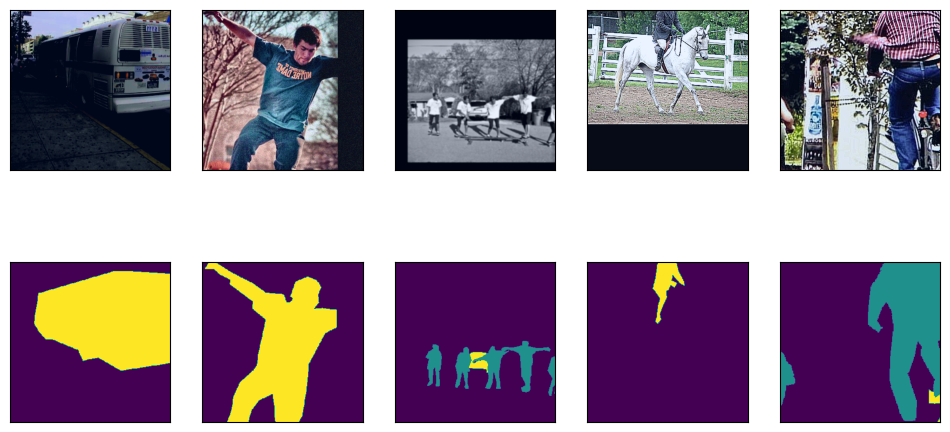

In [119]:
# build a dataset
train_dataset = MySegmentDataset(
    csv_file="data/data.csv",
    transforms=get_train_augmentation(),
    split="train"
)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
for i in range(5):
    img, msk = train_dataset[i]
    print(
        f"img: {img.shape} min: {img.min():.2f} max: {img.max():.2f}, "
        f"msk: {msk.shape} unique values: {np.unique(msk)}"
    )
    img = img.numpy().transpose(1, 2, 0)
    img = (img - img.min()) / (img.max() - img.min())
    axes[0, i].imshow(img)
    axes[1, i].imshow(msk[0])

    
[[ax.set_xticks([]), ax.set_yticks([])]  for ax in axes.flatten()]
plt.show()

In [120]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name=ENCODER_NAME,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=3,
    classes=len(train_dataset.CLASS_NAMES),
)
model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [121]:


train_dataset = MySegmentDataset(
    csv_file="data/data.csv",
    transforms=get_train_augmentation(),
    split="train"
)

val_dataset = MySegmentDataset(
    csv_file="data/data.csv",
    transforms=get_val_augmentation(),
    split="val"
)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size,
    shuffle=True, num_workers=4,
)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size,
    shuffle=False, num_workers=4,
)

batch = next(iter(train_loader))
print(f"batch images: {batch[0].shape}, masks: {batch[1].shape}")
print(f"batch images: {batch[0].dtype}, masks: {batch[1].dtype}")

Class map: {0: 0, 63: 1, 127: 2, 191: 3, 255: 4}
Class map: {0: 0, 63: 1, 127: 2, 191: 3, 255: 4}


batch images: torch.Size([8, 3, 320, 320]), masks: torch.Size([8, 1, 320, 320])
batch images: torch.float32, masks: torch.int64


In [126]:
# setup learning
optimizer = optim.Adam([dict(params=model.parameters(), lr=0.0001)])
criterion = nn.CrossEntropyLoss()

model.train()

for epoch in range(num_epochs):
    loop = tqdm(train_loader, unit="batch")
    for batch_idx, (img, msk) in enumerate(loop):
        loop.set_description(f"Epoch {epoch}")
        img = img.to(device)
        msk = msk.to(device)
        output = model(img)
        loss = criterion(output, msk.squeeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())

Epoch 0:   4%|▎         | 32/865 [00:12<05:34,  2.49batch/s, loss=1.47]


KeyboardInterrupt: 